In [74]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

Z_tab = Table.read("gal_fiboh_dr7_v5_2.fits")
M_tab = Table.read("totlgm_dr7_v5_2.fit")
S_tab = Table.read("gal_totsfr_dr7_v5_2.fits")

idx = np.where((M_tab['MEDIAN']>0) & (Z_tab['MEDIAN']>0) & (S_tab['MEDIAN']>-50))
M = M_tab['MEDIAN'][idx]
Z = Z_tab['MEDIAN'][idx]
S = S_tab['MEDIAN'][idx]

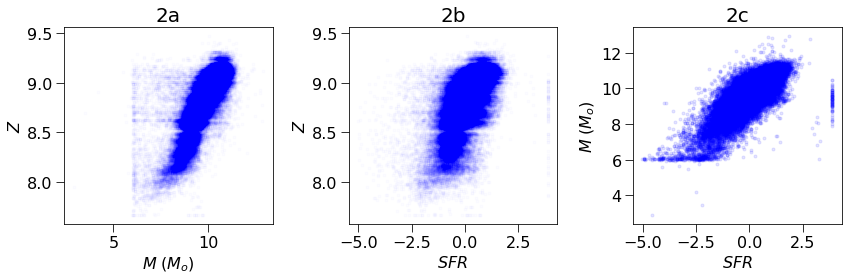

In [90]:
plt.figure(1, figsize=(12,4))
plt.subplot(131); plt.title('2a');
plt.plot(M, Z, 'b.', alpha=0.01)
plt.xlabel('$M\;(M_{o})$', fontsize=16); plt.ylabel('$Z$', fontsize=16)

plt.subplot(132); plt.title('2b')
plt.plot(S, Z, 'b.', alpha=0.01)
plt.xlabel('$SFR$', fontsize=16); plt.ylabel('$Z$', fontsize=16);

plt.subplot(133); plt.title('2c')
plt.plot(S, M, 'b.', alpha=0.1)
plt.xlabel('$SFR$', fontsize=16); plt.ylabel('$M\;(M_{o})$', fontsize=16)
plt.tight_layout()

2a) The dependence of metallicity on solar mass may be in part explained by outflows.  Galaxies of smaller mass have lower metal abundances because their lower escape velocities (Yates et al, 2011)

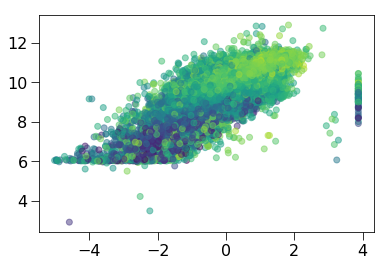

In [85]:
plt.figure(2)
plt.scatter(S, M, c=Z, alpha=0.5)